In [42]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np 
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from aind_behavior_gym.dynamic_foraging.task import (CoupledBlockTask,
                                                     RandomWalkTask,
                                                     UncoupledBlockTask)
from aind_dynamic_foraging_models import generative_model
from aind_dynamic_foraging_models.generative_model import ForagerCollection
from aind_behavior_gym.dynamic_foraging.agent.random_agent import RandomAgent, RandomAgentBiasedIgnore
from aind_dynamic_foraging_models.generative_model.params import ParamsSymbols
from aind_dynamic_foraging_models.generative_model.params.util import get_params_options
from aind_dynamic_foraging_basic_analysis import compute_foraging_efficiency


sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/learning_dynamics_behavior/metric_dev/foraging_choice')
from foraging_choice import compute_foraging_choice


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
forager_collection = ForagerCollection()
df = forager_collection.get_all_foragers()
df.columns

Index(['agent_class_name', 'agent_kwargs', 'agent_alias',
       'number_of_learning_rate', 'number_of_forget_rate', 'choice_kernel',
       'action_selection', 'preset_name', 'n_free_params', 'params', 'forager',
       'win_stay_lose_switch'],
      dtype='object')

In [4]:
df[['agent_class_name', 'preset_name', 'n_free_params', 'params']]

,agent_class_name,preset_name,n_free_params,params
0,ForagerQLearning,None,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
1,ForagerQLearning,Rescorla-Wagner,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
2,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
3,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
4,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
5,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
6,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
7,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
8,ForagerQLearning,Bari2019,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
9,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."


In [5]:
df['params'].unique()

array(['ParamsSymbols.learn_rate, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size (fixed), ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size (fixed), ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size, ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size, ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.forget_rate_unchosen, ParamsSymbols.biasL, ParamsSymbols.softmax_i

In [6]:
# Initialize agent

forager = ForagerCollection().get_preset_forager('Hattori2019', seed=42)
forager.set_params(
    softmax_inverse_temperature=5,
    biasL=0
)

# Create task environment

task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

In [8]:
forager.params

ParamsModel(learn_rate_rew=0.5, learn_rate_unrew=0.1, forget_rate_unchosen=0.2, biasL=0.0, softmax_inverse_temperature=5.0)

Foraging efficiency: 0.7725 (random seed: 0.7769607843137255)
foraging_choice_local: 0.42366421104240537, (foraging_choice_global: 0.3155)


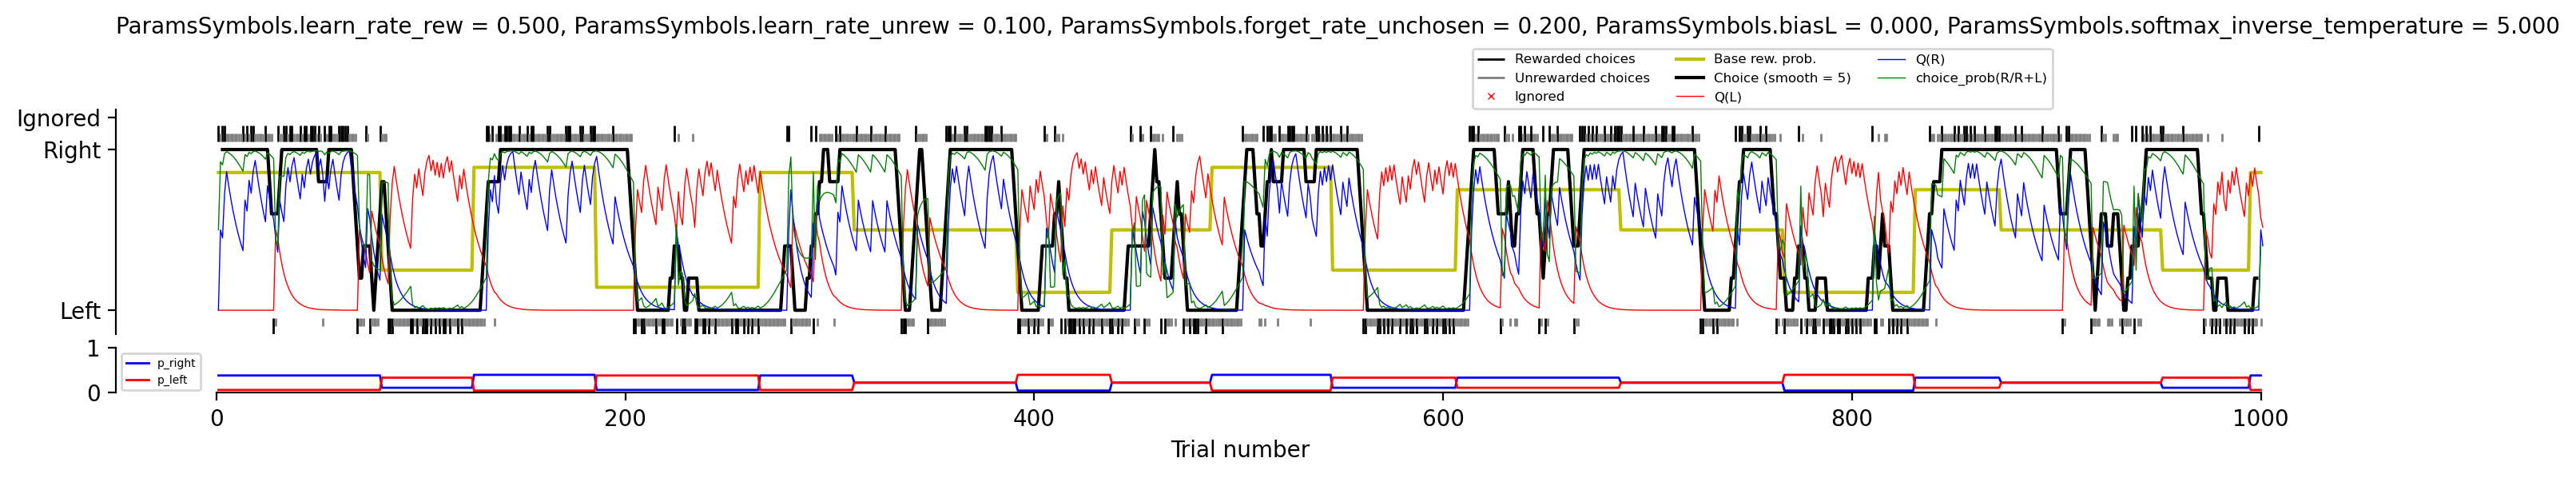

In [9]:
# Run the model
forager.perform(task)

# Get results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value

# Evaluate the foraging efficiency
foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
    baited=task.reward_baiting,
    choice_history=forager.get_choice_history(),
    reward_history=forager.get_reward_history(),
    p_reward=forager.get_p_reward(),
    random_number=task.random_numbers.T,
)

print(f"Foraging efficiency: {foraging_eff:.4f} (random seed: {foraging_eff_random_seed})")

foraging_choice_local, foraging_choice_global = compute_foraging_choice(
    choice_history=forager.get_choice_history(),
    reward_history=forager.get_reward_history(),
    p_reward=forager.get_p_reward(),
    global_calc=None
)

print(f'foraging_choice_local: {foraging_choice_local}, (foraging_choice_global: {foraging_choice_global})')

# Get history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot session
fig, axes = forager.plot_session(if_plot_latent=True)

In [10]:
def run_model(n_iterations, task, forager):
    """
    Run model n_iterations and return foraging choice vector 
    """
    local_metrics = []
    global_metrics = []

    foraging_efficiency = []
    foraging_efficiency_random_seed = []

    for _ in range(n_iterations):
        # reset and run model
        forager.reset()
        forager.perform(task)

        # Calculate metrics
        local_metric, global_metric = compute_foraging_choice(
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            global_calc=None
        )

        local_metrics.append(local_metric)
        global_metrics.append(global_metric)

        foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
            baited=task.reward_baiting,
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            random_number=task.random_numbers.T,
        )

        foraging_efficiency.append(foraging_eff)
        foraging_efficiency_random_seed.append(foraging_eff_random_seed)

    return np.array(local_metrics), np.array(global_metrics), np.array(foraging_efficiency), np.array(foraging_efficiency_random_seed)

In [11]:
n_iterations = 1000

local_metrics, global_metrics, foraging_efficiency, foraging_efficiency_random_seed = run_model(n_iterations, task, forager)


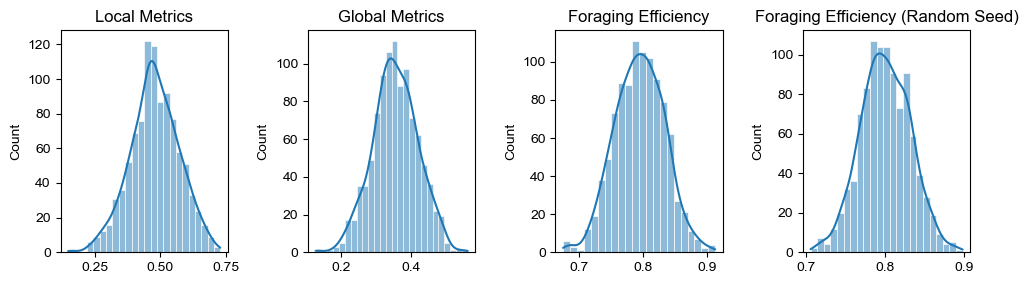

In [62]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))
sns.set_theme(style="whitegrid")
sns.histplot(x=local_metrics, kde=True, ax=ax1, label='local_metric')
ax1.set_title('Local Metrics')

sns.histplot(x=global_metrics, kde=True, ax=ax2, label='global_metric')
ax2.set_title('Global Metrics')

sns.histplot(x=foraging_efficiency, kde=True, ax=ax3, label='foraging_efficiency')
ax3.set_title('Foraging Efficiency')

sns.histplot(x=foraging_efficiency_random_seed, kde=True, ax=ax4, label='foraging_efficiency_random_seed')
ax4.set_title('Foraging Efficiency (Random Seed)')

plt.tight_layout()


In [45]:
def param_sweep(tasks, foragers, param_ranges=None, n_repeats=1):
    """
    Sweep over learning rates for metric evaluation

    Params:
    tasks: dict of task environments 
    foragers: dict of forager agents
    param_ranges (dict, optional): dictionary of parameter names and ranges to sweep over, if None use default ranges
    n_repeats (int, optional): number of repeats to run for each parameter combination

    Returns:
    pd.DataFrame: DataFrame containing parameter combinations, task types, agent types, and metrics 
    """
    if param_ranges is None:
        param_ranges = {
            'learn_rate_rew': np.linspace(0.1, 0.9, 5),
            'learn_rate_unrew': np.linspace(0.05, 0.3, 5),
            'forget_rate_unchosen': np.linspace(0.05, 0.3, 5)
        }

    # Convert single instances to dict format
    if not isinstance(tasks, dict):
        tasks = {'default_task': tasks}
    if not isinstance(foragers, dict):
        foragers = {'default_agent': foragers}

    results = []

    # Fixed parameters
    fixed_params = {
        'softmax_inverse_temperature': 5,
        'biasL': 0
    }

    # Calculate total iterations for progress bar
    total_iters = (len(param_ranges['learn_rate_rew']) * 
                  len(param_ranges['learn_rate_unrew']) * 
                  len(param_ranges['forget_rate_unchosen']) * 
                  len(tasks) * len(foragers) * n_repeats)

    # Create progress bar
    pbar = tqdm(total=total_iters)

    # Iterate through parameters 
    for lr_rew in param_ranges['learn_rate_rew']:
        for lr_unrew in param_ranges['learn_rate_unrew']:
            for fr_unchosen in param_ranges['forget_rate_unchosen']:
                # Set parameters
                params = {
                    'learn_rate_rew': lr_rew,
                    'learn_rate_unrew': lr_unrew,
                    'forget_rate_unchosen': fr_unchosen,
                    **fixed_params
                }

                # Iterate through task types
                for task_name, task in tasks.items():
                    # Iterate through forager types
                    for agent_name, forager in foragers.items():
                        # Repeat n times for each parameter combination
                        for repeat in range(n_repeats):
                            forager.reset()
                            forager.params = forager.params.model_copy(update=params)
                            forager.perform(task)

                            # Calculate metrics 
                            local_metric, global_metric = compute_foraging_choice(
                                choice_history=forager.get_choice_history(),
                                reward_history=forager.get_reward_history(),
                                p_reward=forager.get_p_reward(),
                                global_calc=None
                            )

                            foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
                                baited=task.reward_baiting,
                                choice_history=forager.get_choice_history(),
                                reward_history=forager.get_reward_history(),
                                p_reward=forager.get_p_reward(),
                                random_number=task.random_numbers.T,
                            )

                            # Store results
                            results.append({
                                'task_type': task_name,
                                'agent_type': agent_name,
                                'repeat': repeat,
                                'learn_rate_rew': lr_rew,
                                'learn_rate_unrew': lr_unrew,
                                'forget_rate_unchosen': fr_unchosen,
                                'local_metric': local_metric,
                                'global_metric': global_metric,
                                'foraging_efficiency': foraging_eff,
                                'foraging_efficiency_random_seed': foraging_eff_random_seed
                            })
                            
                            # Update progress bar
                            pbar.update(1)
                            
    pbar.close()
    return pd.DataFrame(results)


In [47]:
# Set parameter and condition ranges

tasks = {
    'coupled_baited': CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42),
    'coupled_unbaited': CoupledBlockTask(reward_baiting=False, num_trials=1000, seed=42),
    'uncoupled_baited': UncoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42),
    'uncoupled_unbaited': UncoupledBlockTask(reward_baiting=False, num_trials=1000, seed=42)
}

foragers = {
    'Hattori2019': ForagerCollection().get_preset_forager('Hattori2019', seed=42)
    }

custom_ranges = {
    'learn_rate_rew': np.linspace(0.01, 1, 40),
    'learn_rate_unrew': np.linspace(0.01, 1, 40),
    'forget_rate_unchosen': np.linspace(0.01, 1, 40)
}
# Run the parameter sweep
results_df = param_sweep(tasks, foragers, custom_ranges)

  0%|          | 111/256000 [00:03<2:26:04, 29.20it/s]

KeyboardInterrupt: 

In [48]:
results_df

,task_type,agent_type,repeat,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,local_metric,global_metric,foraging_efficiency,foraging_efficiency_random_seed
0,coupled_baited,Hattori2019,0,0.01,0.01,0.010000,0.016463,0.021459,0.901640,0.906863
1,coupled_unbaited,Hattori2019,0,0.01,0.01,0.010000,-0.032918,0.002214,0.688643,0.673591
2,uncoupled_baited,Hattori2019,0,0.01,0.01,0.010000,0.050630,0.018500,0.780918,0.792929
3,uncoupled_unbaited,Hattori2019,0,0.01,0.01,0.010000,0.135837,0.010500,0.724784,0.736457
4,coupled_baited,Hattori2019,0,0.01,0.01,0.035385,0.069987,0.052286,0.874461,0.867788
...,...,...,...,...,...,...,...,...,...,...
255995,uncoupled_unbaited,Hattori2019,0,1.00,1.00,0.974615,0.493593,0.286500,0.860900,0.861601
255996,coupled_baited,Hattori2019,0,1.00,1.00,1.000000,0.225316,0.186010,0.844140,0.850242
255997,coupled_unbaited,Hattori2019,0,1.00,1.00,1.000000,0.207253,0.175235,0.684418,0.664000
255998,uncoupled_baited,Hattori2019,0,1.00,1.00,1.000000,0.337094,0.229500,0.841892,0.852086


  0%|          | 111/256000 [00:19<2:26:04, 29.20it/s]

In [49]:
# Find closest values in the actual data

closest_forget = results_df['forget_rate_unchosen'].iloc[(results_df['forget_rate_unchosen'] - 0.2).abs().argsort()[0]]
closest_unrew = results_df['learn_rate_unrew'].iloc[(results_df['learn_rate_unrew'] - 0.1).abs().argsort()[0]]
closest_rew = results_df['learn_rate_rew'].iloc[(results_df['learn_rate_rew'] - 0.5).abs().argsort()[0]]

print(f'Closest forget rate: {closest_forget}, Closest learn rate unrew: {closest_unrew}, Closest learn rate rew: {closest_rew}')

Closest forget rate: 0.18769230769230769, Closest learn rate unrew: 0.11153846153846153, Closest learn rate rew: 0.4923076923076923


In [50]:
# Filter to keep other parameters constant

rew_lr_df = results_df[results_df['forget_rate_unchosen'] == closest_forget]
rew_lr_df = rew_lr_df[rew_lr_df['learn_rate_unrew'] == closest_unrew]

unrew_lr_df = results_df[results_df['learn_rate_rew'] == closest_rew]
unrew_lr_df = unrew_lr_df[unrew_lr_df['forget_rate_unchosen'] == closest_forget]

fr_unchosen_df = results_df[results_df['learn_rate_rew'] == closest_rew]
fr_unchosen_df = fr_unchosen_df[fr_unchosen_df['learn_rate_unrew'] == closest_unrew]


In [51]:
# Create task specific DataFrames

coupled_baiting_df = results_df[results_df['task_type'] == 'coupled_baited']
uncoupled_baiting_df = results_df[results_df['task_type'] == 'uncoupled_baited']
coupled_df = results_df[results_df['task_type'] == 'coupled_unbaited']
uncoupled_df = results_df[results_df['task_type'] == 'uncoupled_unbaited']


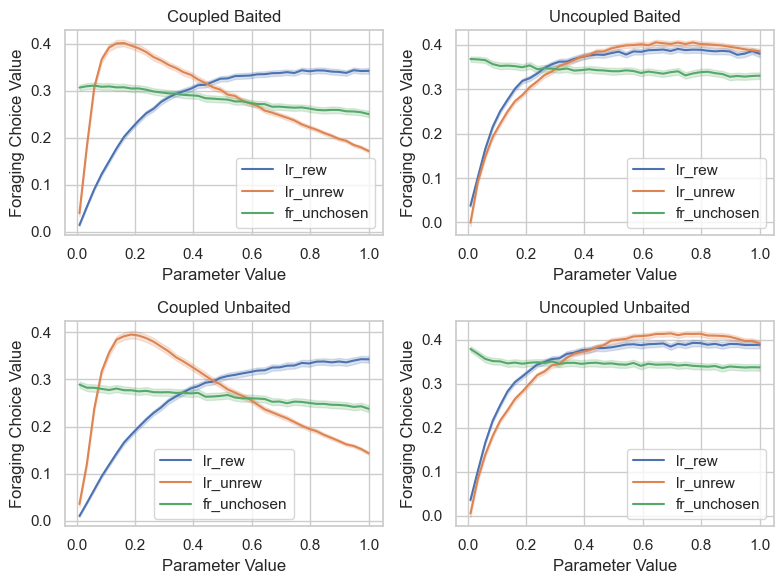

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

task_data = {
    (0,0): (coupled_baiting_df, 'Coupled Baited'),
    (0,1): (uncoupled_baiting_df, 'Uncoupled Baited'),
    (1,0): (coupled_df, 'Coupled Unbaited'),
    (1,1): (uncoupled_df, 'Uncoupled Unbaited')
}

for (i,j), (task_df, title) in task_data.items():
    sns.lineplot(data=task_df, x='learn_rate_rew', y='local_metric', 
                label='lr_rew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='learn_rate_unrew', y='local_metric', 
                label='lr_unrew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='forget_rate_unchosen', y='local_metric', 
                label='fr_unchosen', ax=axes[i,j])

    axes[i,j].set_title(title)
    axes[i,j].set_xlabel('Parameter Value')
    axes[i,j].set_ylabel('Foraging Choice Value')
    axes[i,j].legend()

plt.tight_layout()
plt.show()

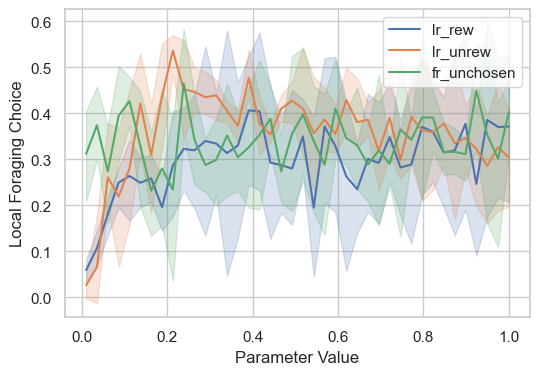

In [64]:
plt.figure(figsize=(6, 4))
sns.lineplot(rew_lr_df, x='learn_rate_rew', y='local_metric', label='lr_rew')
sns.lineplot(unrew_lr_df, x='learn_rate_unrew', y='local_metric', label='lr_unrew')
sns.lineplot(fr_unchosen_df, x='forget_rate_unchosen', y='local_metric', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Local Foraging Choice')
plt.legend()
plt.show()

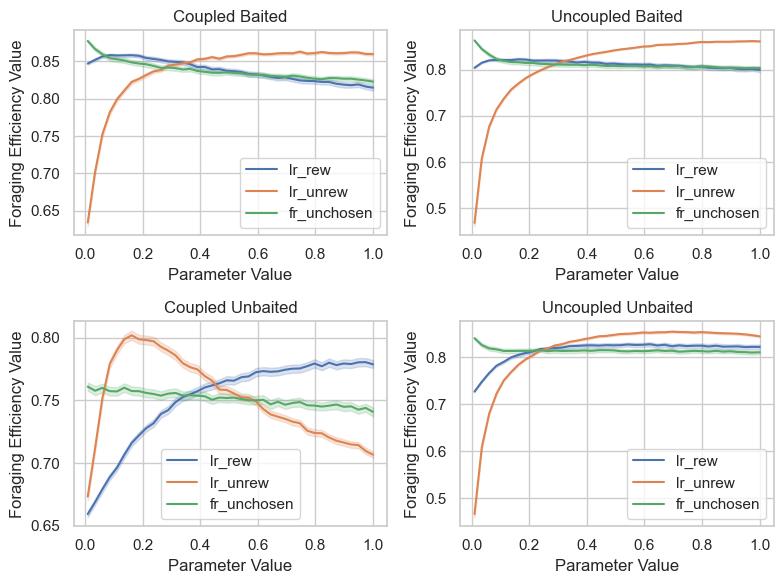

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for (i,j), (task_df, title) in task_data.items():
    sns.lineplot(data=task_df, x='learn_rate_rew', y='foraging_efficiency', 
                label='lr_rew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='learn_rate_unrew', y='foraging_efficiency', 
                label='lr_unrew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='forget_rate_unchosen', y='foraging_efficiency', 
                label='fr_unchosen', ax=axes[i,j])
    
    axes[i,j].set_title(title)
    axes[i,j].set_xlabel('Parameter Value')
    axes[i,j].set_ylabel('Foraging Efficiency Value')
    axes[i,j].legend()

plt.tight_layout()
plt.show()

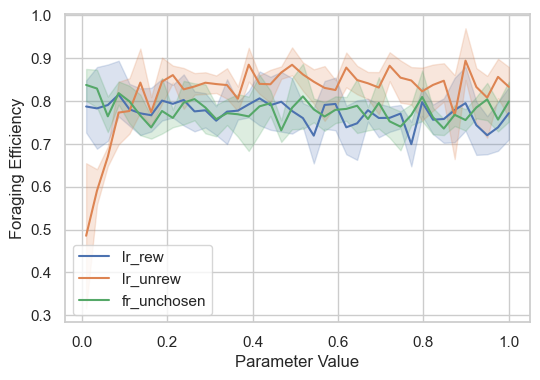

In [66]:
plt.figure(figsize=(6, 4))
sns.lineplot(rew_lr_df, x='learn_rate_rew', y='foraging_efficiency', label='lr_rew')
sns.lineplot(unrew_lr_df, x='learn_rate_unrew', y='foraging_efficiency', label='lr_unrew')
sns.lineplot(fr_unchosen_df, x='forget_rate_unchosen', y='foraging_efficiency', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Foraging Efficiency')
plt.legend()
plt.show()


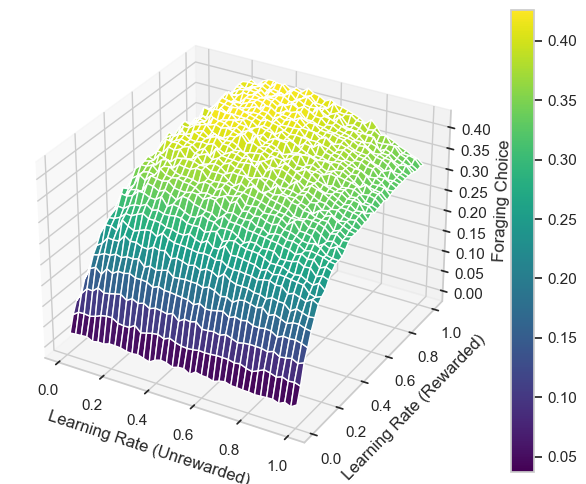

In [67]:
# Additional plots (mean FC / lr_rew, lr_unrew)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')

pivot = results_df.pivot_table(
    values='local_metric',
    index='learn_rate_rew', 
    columns='learn_rate_unrew',
    aggfunc='mean'
)
X, Y = np.meshgrid(pivot.columns, pivot.index)

surf = ax.plot_surface(X, Y, pivot.values, cmap='viridis')
ax.set_xlabel('Learning Rate (Unrewarded)')
ax.set_ylabel('Learning Rate (Rewarded)') 
ax.set_zlabel('Foraging Choice')
plt.colorbar(surf)
plt.show()

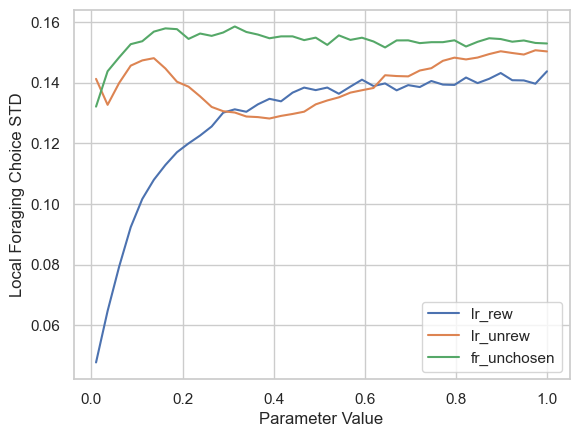

In [68]:
# Parameter sensitivity 
sensitivity_fc = pd.DataFrame({
    'learn_rate_rew': results_df.groupby('learn_rate_rew')['local_metric'].std(),
    'learn_rate_unrew': results_df.groupby('learn_rate_unrew')['local_metric'].std(),
    'forget_rate': results_df.groupby('forget_rate_unchosen')['local_metric'].std()
})

sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='learn_rate_rew', label='lr_rew')
sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='learn_rate_unrew', label='lr_unrew')
sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='forget_rate', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Local Foraging Choice STD')
plt.legend()
plt.show()


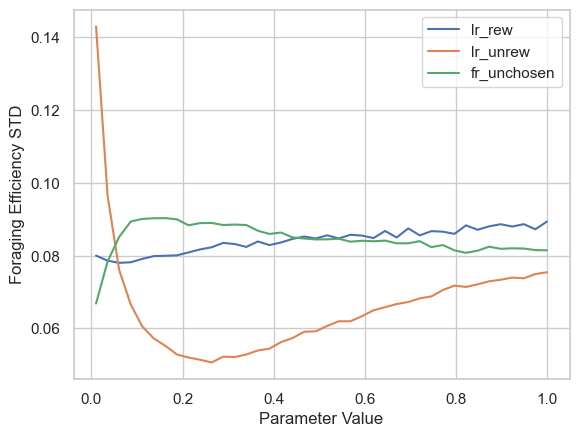

In [69]:
# Parameter sensitivity 
sensitivity_fe = pd.DataFrame({
    'learn_rate_rew': results_df.groupby('learn_rate_rew')['foraging_efficiency'].std(),
    'learn_rate_unrew': results_df.groupby('learn_rate_unrew')['foraging_efficiency'].std(),
    'forget_rate': results_df.groupby('forget_rate_unchosen')['foraging_efficiency'].std()
})

sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='learn_rate_rew', label='lr_rew')
sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='learn_rate_unrew', label='lr_unrew')
sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='forget_rate', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Foraging Efficiency STD')
plt.legend()
plt.show()


In [70]:
# Parameter recovery 

# Fit model to recover parameters

forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override = {'softmax_inverse_temperature': [0, 100]},
    clamp_params = {'biasL': 0},
    DE_kwargs = dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation = None,
)

fitting_results = forager.fitting_result

2024-12-18 12:15:35,201 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 289.0829807952948
differential_evolution step 2: f(x)= 278.66081064312925
differential_evolution step 3: f(x)= 271.07233761947083
differential_evolution step 4: f(x)= 271.07233761947083
differential_evolution step 5: f(x)= 271.07233761947083
differential_evolution step 6: f(x)= 267.7258166159626
differential_evolution step 7: f(x)= 267.7258166159626
differential_evolution step 8: f(x)= 267.7258166159626
differential_evolution step 9: f(x)= 261.55107374493673
differential_evolution step 10: f(x)= 261.1578133089714
differential_evolution step 11: f(x)= 261.1578133089714
differential_evolution step 12: f(x)= 259.92281388759886
differential_evolution step 13: f(x)= 258.0116776498438
differential_evolution step 14: f(x)= 258.0116776498438
differential_evolution step 15: f(x)= 258.0116776498438
differential_evolution step 16: f(x)= 258.0116776498438
differential_evolution step 17: f(x)= 258.0116776498438
differential_evolution step 18: f(x)= 258.011677649

In [71]:
# Check fitted parameters 
fit_names = fitting_results.fit_settings['fit_names']
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f'Num of trials: {len(choice_history)}')
print(f'Fitted parameters: {fit_names}')
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_results.x]}')
print(f"Likelihood-Per-Trial: {fitting_results.LPT}")
print(f"Prediction accuracy full dataset: {fitting_results.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.5000', '0.1000', '0.2000', '5.0000']
Fitted:       ['0.6011', '0.1087', '0.1544', '4.8908']
Likelihood-Per-Trial: 0.7732456884626638
Prediction accuracy full dataset: 0.902



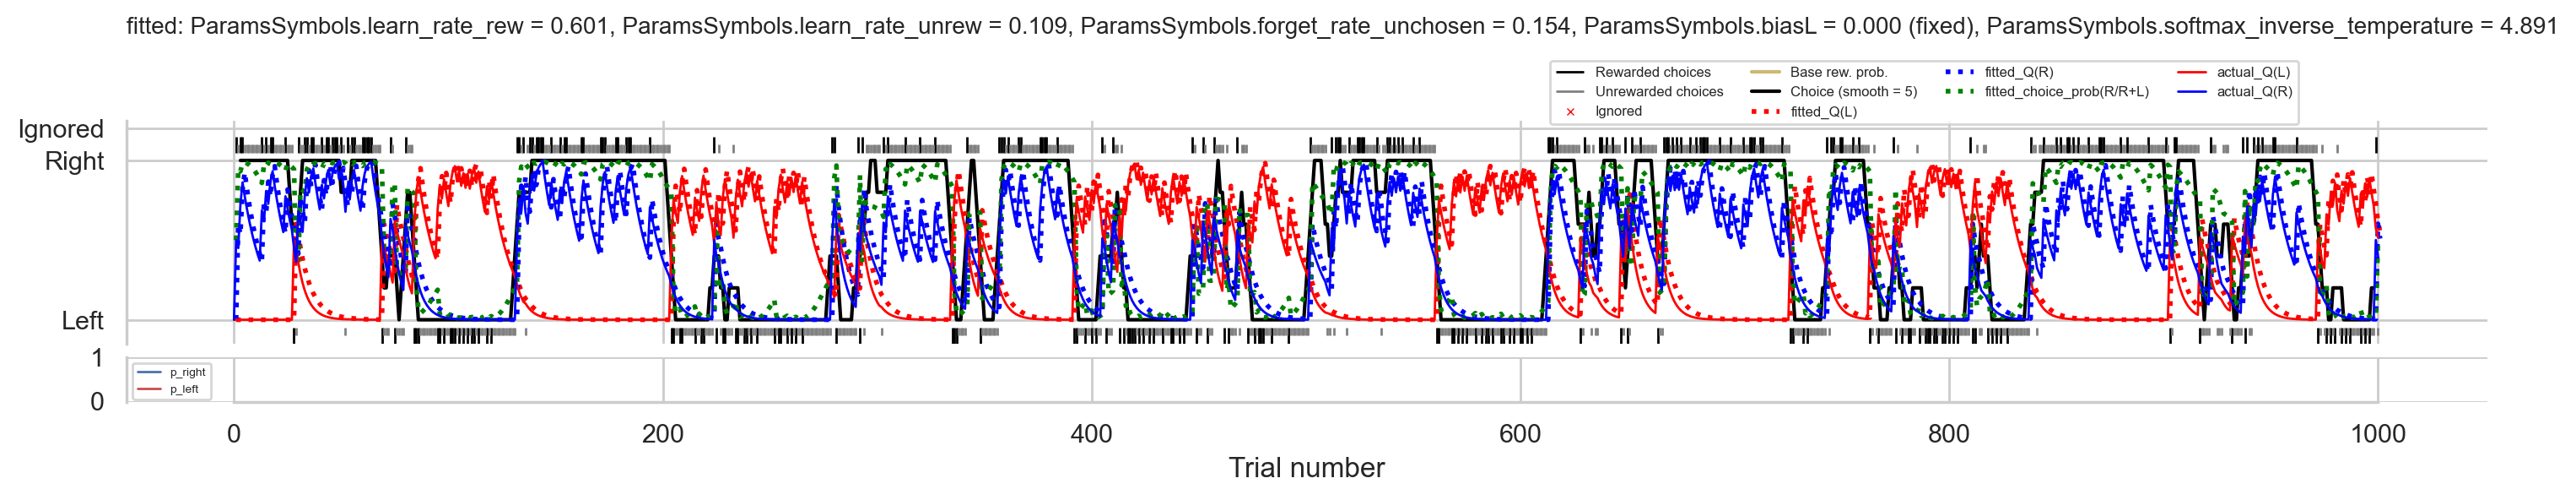

In [72]:
# Plot fitted session results

fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay ground truth Q values
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)